# Introduction to Scikit-learn

Last update June, 13 2023

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
from IPython.display import Markdown, display

## Predicting galaxy redshift via regression on 3D-HST photometry

### Download data

First, download the 3D-HST catalog from the MAST archive. This dataset is described in [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24).

In [38]:
from astropy.utils.data import download_file
import tarfile

file_url = 'https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar'
tarfile.open(download_file(file_url, cache=True), "r:")\
       .extract('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', '.')

Read the combined photmetric catalog into a dataframe via astropy

In [2]:
from astropy.table import Table

df = Table.read('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', format='ascii').to_pandas()
df

id  field          ra        dec         x         y  z_spec  \
0           1.0  AEGIS  215.222382  53.004185   9590.50   3057.30 -1.0000   
1           2.0  AEGIS  215.096588  52.918053  16473.20   3150.20 -1.0000   
2           3.0  AEGIS  215.161469  52.959461  13060.10   2982.30 -1.0000   
3           4.0  AEGIS  215.305298  53.052921   5422.80   2692.10 -1.0000   
4           5.0  AEGIS  215.041840  52.871273  19894.60   2834.40 -1.0000   
...         ...    ...         ...        ...       ...       ...     ...   
207962  44098.0    UDS   34.363106  -5.122067  14578.84  11076.42 -1.0000   
207963  44099.0    UDS   34.333569  -5.123219  16343.92  11007.12 -1.0000   
207964  44100.0    UDS   34.363682  -5.123123  14544.39  11013.01  1.4196   
207965  44101.0    UDS   34.556389  -5.123040   3028.23  11017.04 -1.0000   
207966  44102.0    UDS   34.365097  -5.121975  14459.90  11081.91 -1.0000   

        z_peak  faper_F140W  eaper_F140W  ...  flags  f140w_flag  star_flag  \
0       0.0100     -82.0410   -82.041000  ...      0           0          1   
1       0.0100       3.5078     0.074233  ...      3           0          0   
2       0.2062      -1.9043    -1.904300  ...      1           0          0   
3       0.0355     -72.3250   -72.325000  ...      0           0          0   
4       0.3427    1890.5000     0.133300  ...      0           1          2   
...        ...          ...          ...  ...    ...         ...        ...   
207962  0.1852     188.8200     0.170750  ...      0           1          2   
207963  0.6716       1.7193     0.129080  ...      0           1          2   
207964  2.7489       1.3829     0.113830  ...      0           1          2   
207965  1.1716     -99.0000   -99.000000  ...      1           0          0   
207966  0.6160       1.5335     0.152730  ...      0           1          2   

        use_phot  near_star  nexp_f125w  nexp_f140w  nexp_f160w  lmass   Av  
0              0          0           2           0           3   7.51  1.1  
1              0          0           4           4           4   5.62  0.1  
2              1          0           2           0           2   9.00  1.1  
3              0          0           1           0           1   4.78  0.4  
4              0          1           0           3           0  11.57  0.5  
...          ...        ...         ...         ...         ...    ...  ...  
207962         0          0           0           3           0  10.21  0.2  
207963         0          0           0           3           0   8.49  0.7  
207964         0          0           0           4           0   9.08  1.4  
207965         0          0           1           0           2  10.55  1.0  
207966         0          0           0           3           0   8.58  0.0  

[207967 rows x 38 columns]

### Exploring the dataset

Now we will examine the contents of the catalog. 

The dataset contains standard information such as target `id`, `field` name, coordinates (`ra`, `dec`), fluxes, uncertainties, and various photometric flags (see [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24), or download the [README](https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/master_readme.v4.1.txt) here). 

In addition, there are some derived properties such as photometric redshift (`z_peak`), spectroscopic redshift (`z_spec`), mass (`lmass`) and dust extinction in the V band (`Av`).

[Kriek et al (2018; FAST)](https://ui.adsabs.harvard.edu/abs/2018ascl.soft03008K/abstract) describe the masse estimates.

**Keep in mind that we are interested in predicting redshift, so our "target" variable will be `z_spec`. The "features" will be all relevant columns.**

In [40]:
# Your turn to explore for ~5 minutes.

In [3]:
df.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

In [4]:
df.describe().T

count          mean           std          min           25%  \
id           207967.0  2.117321e+04  1.265041e+04     1.000000  10399.000000   
ra           207967.0  1.220675e+02  7.383123e+01    34.216633     53.061646   
dec          207967.0  1.446509e+01  3.538768e+01   -27.959742     -5.272032   
x            207967.0  1.215648e+04  7.233914e+03     7.400000   7316.685000   
y            207967.0  1.023374e+04  5.733813e+03  1273.020000   6161.300000   
z_spec       207967.0 -9.536530e-01  4.891243e-01   -99.900000     -1.000000   
z_peak       207967.0  1.177393e+00  6.727479e+00   -99.000000      0.817400   
faper_F140W  207967.0 -1.542424e+01  3.237767e+02  -482.630000    -48.633500   
eaper_F140W  207967.0 -2.211378e+01  5.445781e+01  -482.630000    -48.633500   
faper_F160W  207967.0  1.339273e+01  5.961002e+02   -99.000000      0.186090   
eaper_F160W  207967.0 -5.187644e-01  7.605170e+00   -99.000000      0.026516   
f_F606W      207967.0 -7.108241e+00  9.912538e+01   -99.000000      0.070850   
e_F606W      207967.0  1.313269e+16  3.789337e+18   -99.000000      0.020005   
f_F814W      207967.0 -2.199676e+01  1.390750e+02   -99.000000    -99.000000   
e_F814W      207967.0  3.236528e+16  6.628122e+18   -99.000000    -99.000000   
f_F125W      207967.0  1.623084e+01  6.283784e+02   -99.000000      0.227010   
e_F125W      207967.0 -4.258125e-01  1.319884e+01   -99.000000      0.053360   
f_F140W      207967.0 -1.702118e+01  4.170184e+02   -99.000000    -99.000000   
e_F140W      207967.0 -2.656068e+01  8.092820e+01   -99.000000    -99.000000   
f_F160W      207967.0  1.956213e+01  8.029663e+02   -99.000000      0.265040   
e_F160W      207967.0 -3.964592e-01  1.964629e+01   -99.000000      0.051773   
tot_cor      207967.0  1.115344e+00  5.067883e-02     1.000000      1.076500   
kron_radius  207967.0  4.649582e+00  4.175856e+00   -99.000000      3.580000   
a_image      207967.0  3.071895e+00  4.629618e+00   -99.000000      1.840000   
b_image      207967.0  2.115423e+00  4.147367e+00   -99.000000      1.396000   
flux_radius  207967.0  4.191743e+00  3.429291e+01 -5480.000000      2.930000   
fwhm_image   207967.0  1.996158e-01  4.746242e+00   -99.000000      0.000000   
flags        207967.0  5.006419e-01  1.278831e+00     0.000000      0.000000   
f140w_flag   207967.0  3.303409e-03  5.738042e-02     0.000000      0.000000   
star_flag    207967.0  1.310165e+00  9.436616e-01     0.000000      0.000000   
use_phot     207967.0  8.470046e-01  3.599840e-01     0.000000      1.000000   
near_star    207967.0  4.426664e-02  2.056874e-01     0.000000      0.000000   
nexp_f125w   207967.0  8.358509e+00  1.091935e+01     0.000000      4.000000   
nexp_f140w   207967.0  4.425048e+00  9.310295e+00     0.000000      0.000000   
nexp_f160w   207967.0  9.051638e+00  1.519260e+01     0.000000      4.000000   
lmass        207967.0  8.410625e+00  1.511090e+00    -1.000000      7.910000   
Av           207967.0  3.189294e-01  5.449457e-01    -1.000000      0.000000   

                      50%           75%           max  
id           20797.000000  31195.500000  5.050700e+04  
ra             150.091034    189.306900  2.153053e+02  
dec              2.274822     52.957975  6.238830e+01  
x            10578.100000  15137.135000  3.766890e+04  
y             8873.450000  13184.660000  3.075330e+04  
z_spec          -1.000000     -1.000000  6.118000e+00  
z_peak           1.415900      2.128050  5.960900e+00  
faper_F140W      0.178810      0.491190  4.705200e+04  
eaper_F140W      0.069309      0.086337  1.059200e+04  
faper_F160W      0.355380      0.939190  9.118500e+04  
eaper_F160W      0.035040      0.042530  4.745600e+02  
f_F606W          0.188050      0.488610  1.453600e+04  
e_F606W          0.029607      0.039982  1.503200e+21  
f_F814W          0.176220      0.528775  1.786700e+04  
e_F814W          0.033730      0.051859  1.804100e+21  
f_F125W          0.487080      1.381500  1.144900e+05  
e_F125W          0.0707


> Physical parameters mass vs. redshift. 
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.


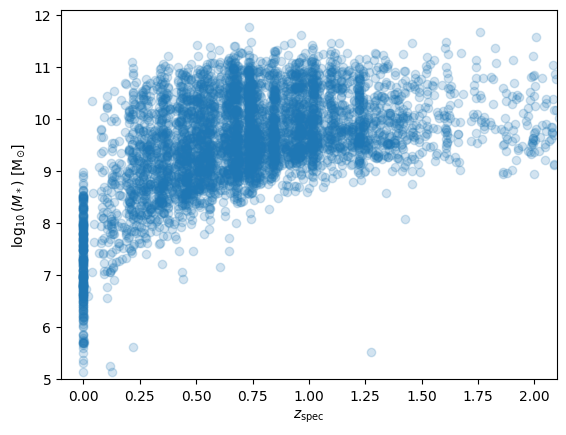

In [5]:
ax = plt.subplot(111)

ax.scatter(df.z_spec, df.lmass, alpha=0.2)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$\log_{10}{(M_*)}$ [M$_{\odot}$]')
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(5., 12.1);
display(Markdown("""
> Physical parameters mass vs. redshift.
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.
"""))

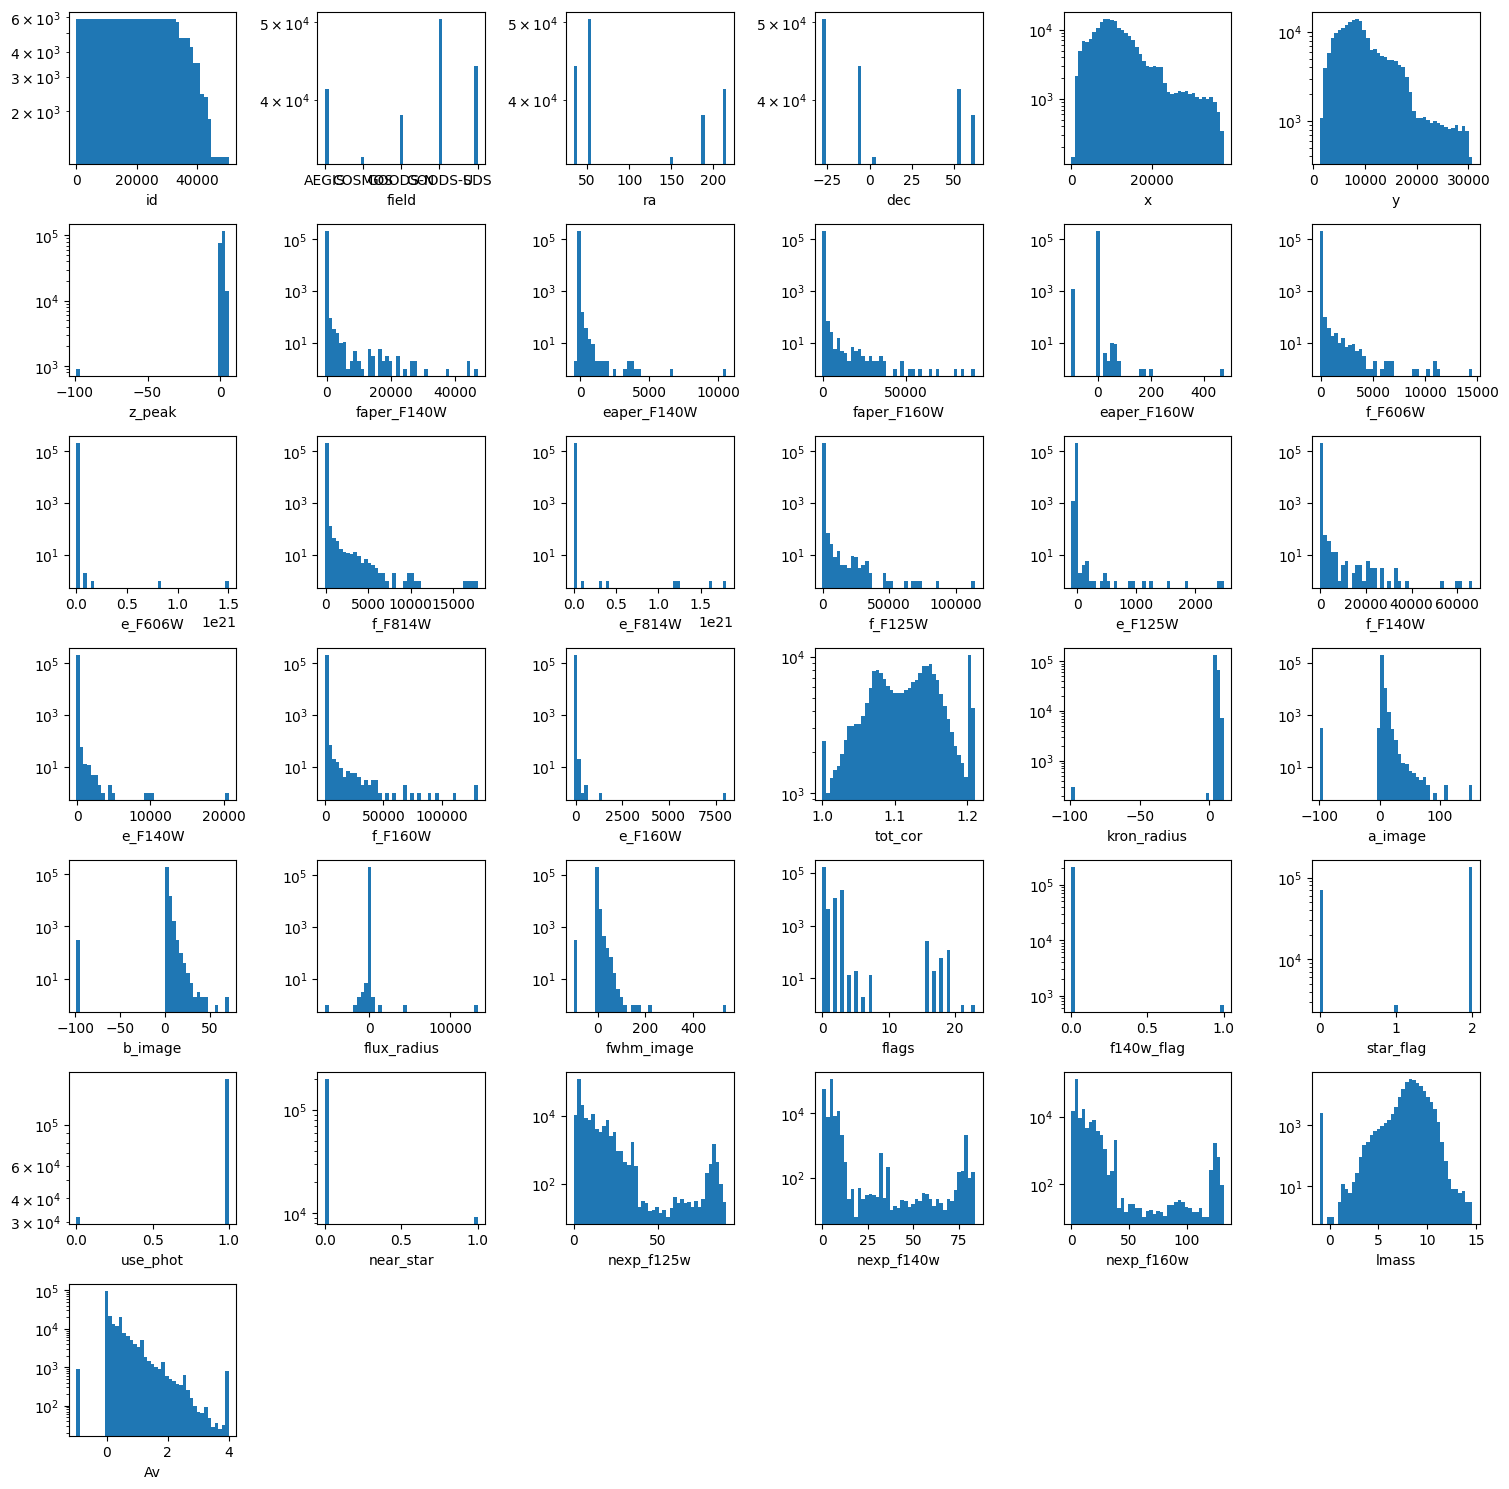

In [6]:
columns = [k for k in df.columns if k != 'z_spec']

wrap = 6

plt.figure(figsize=(15, 15))

nlines = len(columns) // wrap +  int(len(columns) % wrap > 0)

for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.tight_layout()

### Perform data cleaning & select features

Before building and applying a regression model, we first need to inspect and clean the dataset.


Cleaning:
* only keep sources with $log(M)>9$ to remove sources which do not have complete coverage across redshift.
* remove redshift = 0
* We do not keep `z_phot` to avoid leakage.
* The `Av`, `lmass` and `z_peak` values come from the FAST photometric fit, and so we will exclude them as well. 
* We will exclude the categorical flag variables (‘flags’, ‘f140w_flag’, ‘star_flag’, ‘use_phot’, ‘near_star’).

In [8]:
remove = ('Av', 'lmass', 'z_peak', 'flags', 'f140w_flag', 'star_flag',
          'use_phot', 'near_star', 'z_spec', 'id', 'field',
          'ra', 'dec', 'x', 'y')
features = [col for col in df.columns if col not in remove]

target = 'z_spec'

Markdown(f"""
**features** {features}

**target**: {target} """)


**features** ['faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image', 'flux_radius', 'fwhm_image', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w']

**target**: z_spec 

### Filter data and impute missing values

We need to transform text into values/categories. 

In [53]:
from sklearn.preprocessing import LabelEncoder
df['field_lbl'] = LabelEncoder().fit_transform(df['field'])

By inspection of mass vs redshift, we will only keep sources with $log(M)>9$ to remove sources that do not have complete coverage across redshift.

In [9]:
df = df[(df[target] > 0) & (df['lmass'] > 9)]

We use the median of the distributions to replace bad / missing values

In [10]:
ecols = [col for col in features if (col[0] == 'e') and (col[-1] == 'W')]

for col in ecols:
    missing_value = np.nanmedian(df[col])
    df.loc[df[col] < -90, col] = missing_value

In [11]:
df_x = df[features]
df_y = df[target]

In [12]:
df_x

faper_F140W  eaper_F140W  faper_F160W  eaper_F160W   f_F606W  \
26         -71.0650   -71.065000       8.1873     0.049477    3.8503   
69         -60.6090   -60.609000       3.2127     0.052521    1.5757   
82         -40.9920   -40.992000       6.4949     0.052284    4.4121   
144        -33.7210   -33.721000       2.2822     0.035636    2.3501   
154        -54.5630   -54.563000       4.6583     0.055052    1.8658   
...             ...          ...          ...          ...       ...   
205837     -99.0000     0.065174      30.6860     0.032872    6.2959   
206257     -99.0000     0.065174      58.5290     0.033204   15.0210   
207042     -99.0000     0.065174      41.6890     0.048789  102.7100   
207646     -99.0000     0.065174      13.4370     0.054057    7.3063   
207964       1.3829     0.113830     -99.0000     0.033797    1.1099   

         e_F606W   f_F814W   e_F814W   f_F125W   e_F125W  ...  e_F160W  \
26      0.036320    6.3439  0.055958    9.9996  0.079702  ...  0.11941   
69      0.041291    2.6588  0.062491    4.8744  0.093860  ...  0.16605   
82      0.059577    8.6526  0.092122   14.5010  0.135510  ...  0.23213   
144     0.075882    4.2912  0.118310    6.0816  0.115550  ...  0.16608   
154     0.044419    3.4657  0.067187    6.3630  0.104380  ...  0.20044   
...          ...       ...       ...       ...       ...  ...      ...   
205837  0.062144   19.7480  0.062613   51.5940  0.159870  ...  0.22079   
206257  0.075732   45.7970  0.075405  129.2900  0.198170  ...  0.50738   
207042  0.306440  158.0200  0.351600  298.0700  0.533640  ...  0.74396   
207646  0.044850    9.1046  0.045867   11.2820  0.147020  ...  0.14652   
207964  0.065573    1.3620  0.065967  -99.0000  0.092815  ...  0.18208   

        tot_cor  kron_radius  a_image  b_image  flux_radius  fwhm_image  \
26       1.0931         3.50    3.730    3.210         3.38        0.00   
69       1.0717         4.37    3.750    3.140         4.28        0.00   
82       1.0456         3.62    5.560    5.260         6.59        0.00   
144      1.0420         3.50    7.370    4.590         7.78        0.00   
154      1.0623         4.08    5.500    3.070         5.04        0.00   
...         ...          ...      ...      ...          ...         ...   
205837   1.0280         3.50    9.057    5.362         7.00       10.32   
206257   1.0000         3.50   13.952   12.710         9.53        7.50   
207042   1.0000         3.50   21.379    8.268        16.90       43.85   
207646   1.0985         3.50    3.522    3.125         2.84        4.52   
207964   1.0743         5.90    3.040    1.942         5.25        0.00   

        nexp_f125w  nexp_f140w  nexp_f160w  
26               2           0           2  
69               2           0           2  
82               2           0           2  
144              4           0           4  
154              2           0           2  
...            ...         ...         ...  
205837           4           0           4  
206257           4           0           4  
207042           4           0           4  
207646           2           0           2  
207964           0           4           0  

[4173 rows x 23 columns]

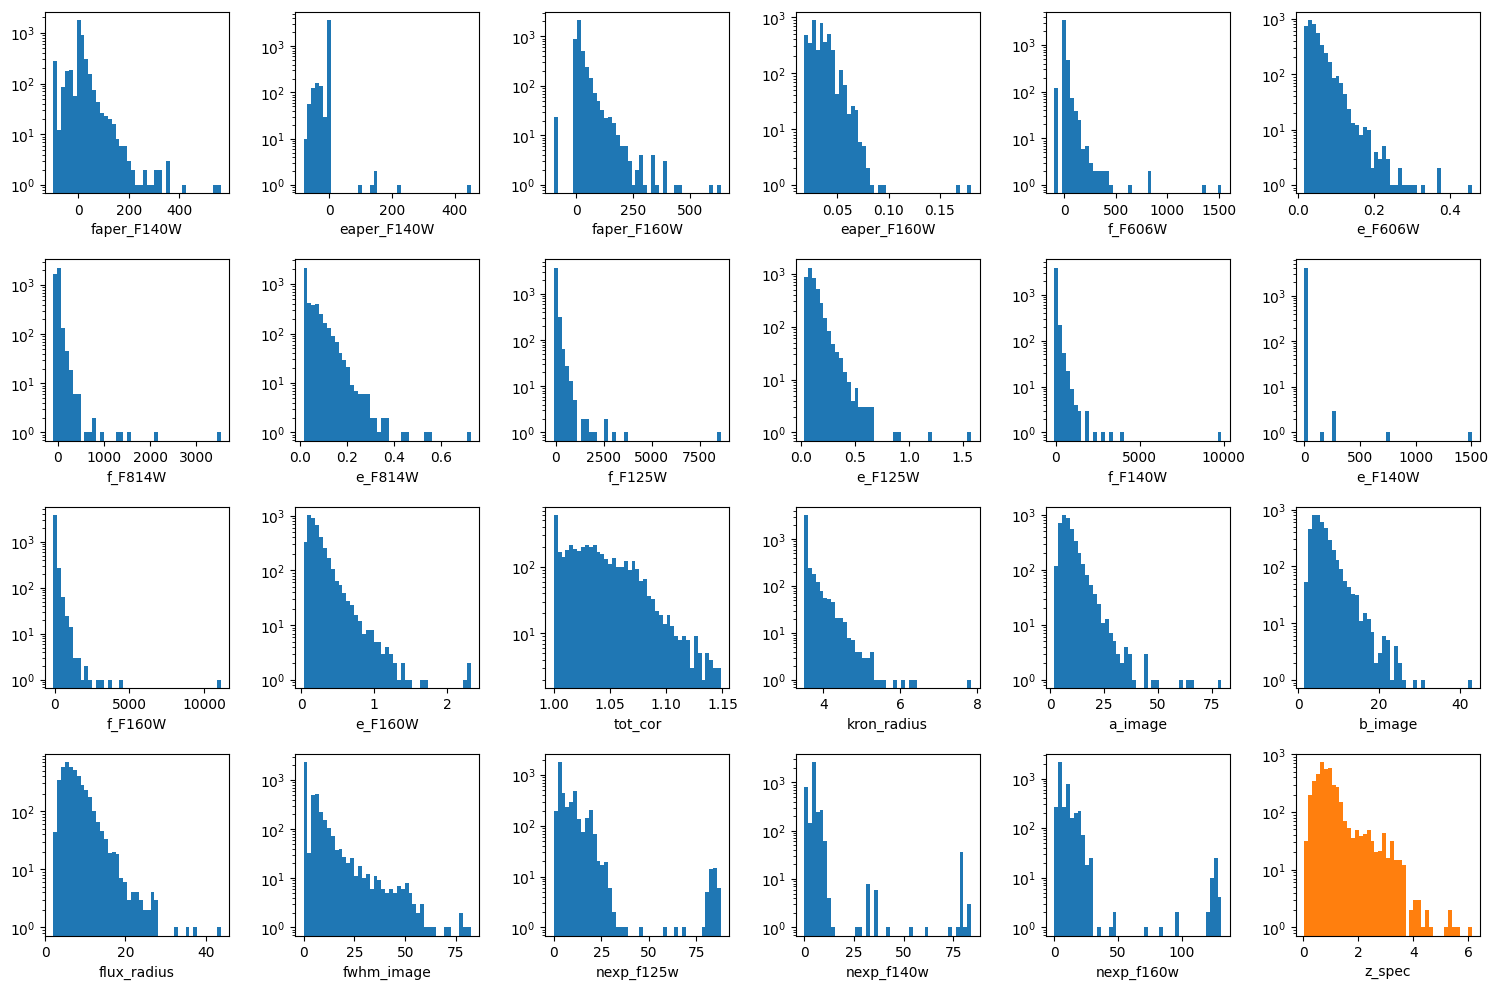

In [13]:
columns = [k for k in df_x.columns]

wrap = 6

plt.figure(figsize=(15, 10))

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0)

for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df_x[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.subplot(nlines, wrap, e + 1)
plt.hist(df_y, bins=43, log=True, color='C1')
plt.xlabel(target)

plt.tight_layout()

### Divide the data into train, test and validation sets

Note that typically one needs to pass arrays to the common libraries. 

```python
X = df[features].values
y = df[target].values
```

However, `Scikit-learn` has implemented pandas interfaces, so we do not need to do so in this particular exercise.



Divide the data into train, validation and test sets. We will use the following definitions:

* **Training**: The data used to update model parameters (e.g., coefficients or matrix element values).

* **Validation**: The data used to update model selection (for instance, we might change hyperparameters of a model based on the validation metrics).

* **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

In [27]:
from sklearn.model_selection import train_test_split

# first reserve 70% of the data for training, 30% for validation
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=42)

# second, split the validation set in half to obtain validation and test sets.
#X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=0.5, random_state=42)

### Explore regression models

Here we explore a few options for regressor models.

#### Linear Regression 

Let's do a simple one first

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

In [23]:
lin.coef_, lin.intercept_

(array([-1.33931690e-03,  5.44362830e-03, -6.41861372e-04, -1.10148937e+01,
        -4.79508115e-05, -1.61033060e+00, -2.19360032e-04,  2.53390421e-03,
        -4.02670520e-03,  8.27056672e-02,  1.71374550e-04, -1.24751795e-03,
         3.07230266e-03,  4.89299577e-01,  1.37654652e+01,  6.55615367e-01,
        -1.38107288e-02,  1.91247374e-02,  2.07340543e-02, -6.04824595e-03,
         1.20082645e-02,  4.61446290e-04, -7.28792366e-03]),
 -15.401068963333204)

To quantify the performance of the model, we will apply it to the validation set and compare the predicted values with the true values by computing the mean squared error:

MSE = 0.2722


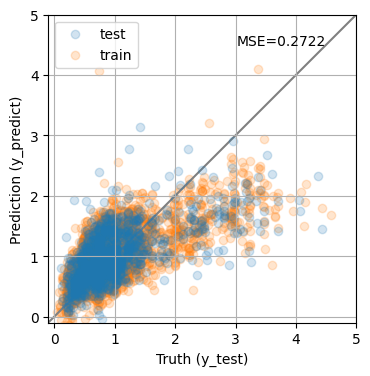

In [24]:
from sklearn.metrics import mean_squared_error

y_predict = lin.predict(X_test)
y_predict0 = lin.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='upper left')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

The MSE is not great. Not surprising given the simplicity of our model. Maybe we can do better changing the model?



Text(0.5, 0, 'Lin. Coeffs')

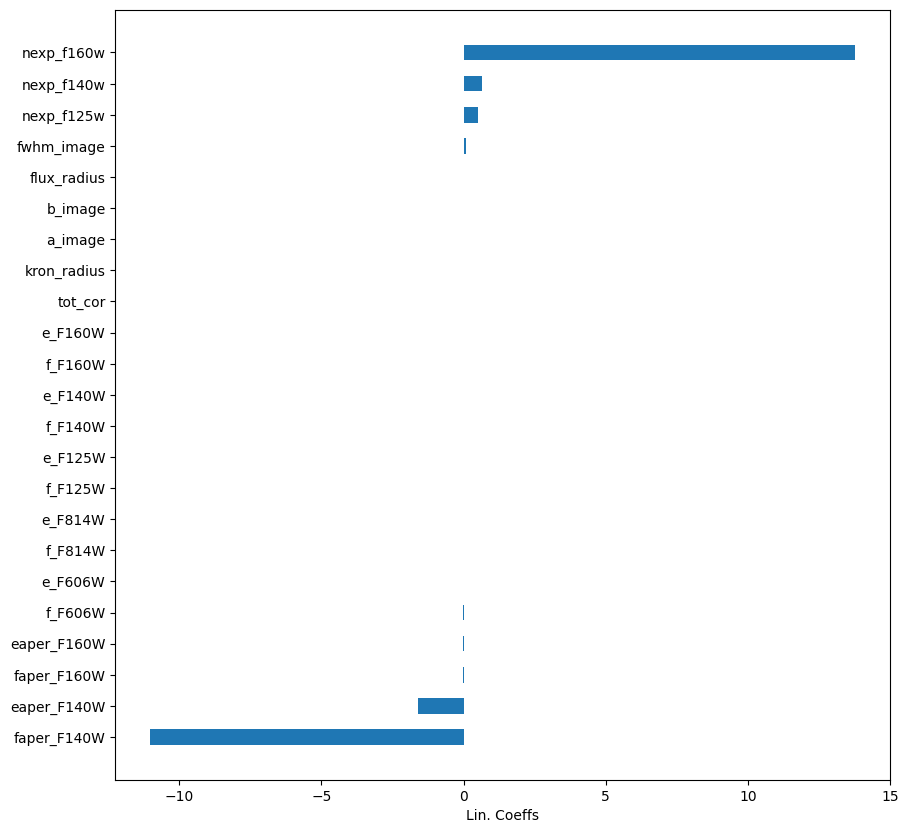

In [26]:
importances = lin.coef_
labels = lin.feature_names_in_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort],
        align='center',
        height=0.5,
        tick_label=labels)
ax.set_xlabel("Lin. Coeffs")

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoLarsIC

pipe = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('classifier', LassoLarsIC(normalize=False))
])

pipe.fit(X_train, y_train)

/Users/fouesneau/Work/projects/astro_ds/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:116: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('classifier', LassoLarsIC(normalize=False))])

MSE = 0.2633


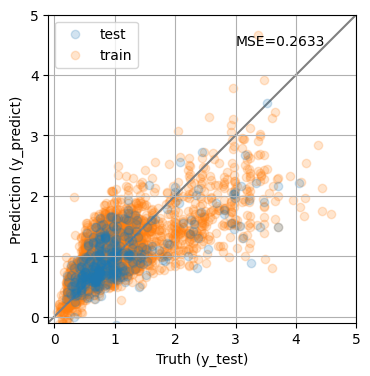

In [30]:
y_predict = pipe.predict(X_test)
y_predict0 = pipe.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

Text(0.5, 0, 'Lin. Coeffs')

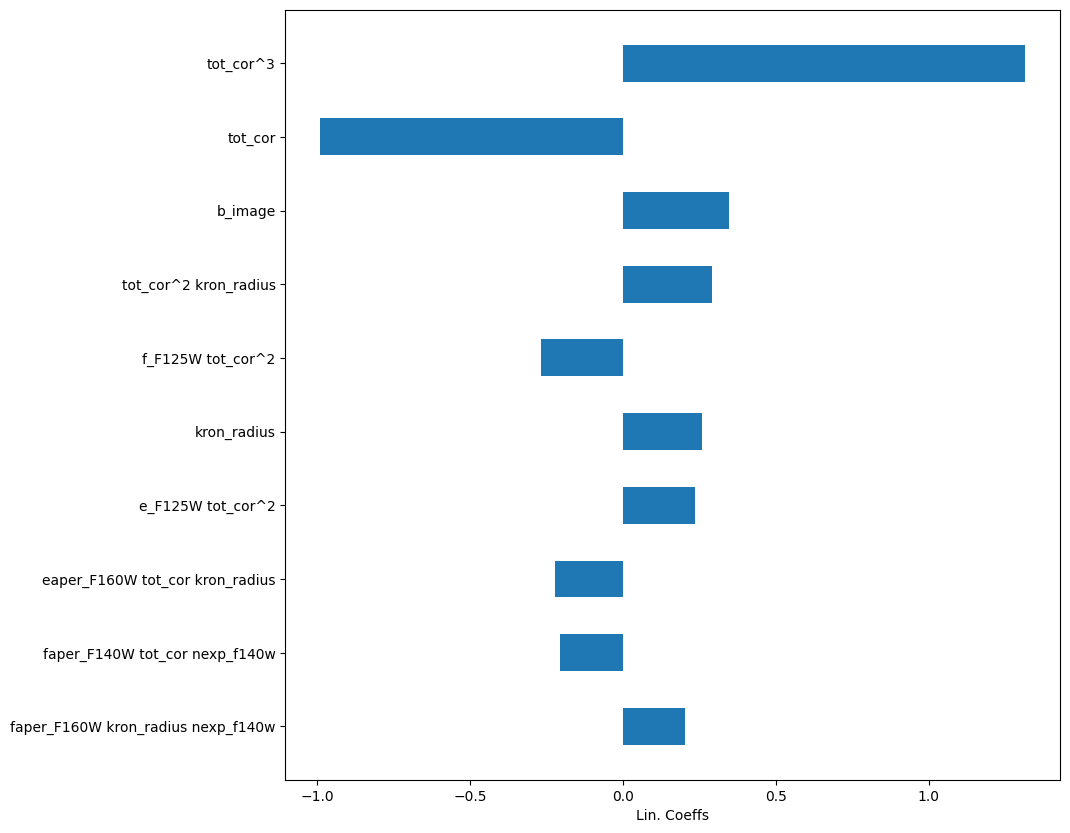

In [31]:
importances = pipe['classifier'].coef_
labels = pipe['polynomial'].get_feature_names_out()
argsort = np.argsort(np.abs(importances))[-10:]

importances = importances[argsort]
labels = labels[argsort]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(labels)), importances,
        align='center',
        height=0.5,
        tick_label=labels)
ax.set_xlabel("Lin. Coeffs")

#### Other models

Using sklearn, it is very easy to change a model for something different.

#### Random Forest

Using sklearn, we can very easily construct a decision tree model for regressing redshift from the photometric catalog features. A decision tree is composed of a series of if-else decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision. In this first example, we will use the DecisionTreeRegressor from sklearn.

In [32]:
from sklearn.ensemble import RandomForestRegressor

# use the same parameters as the Decision Tree
params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
    "max_depth": 15,
}

# Initialize the model
rf = RandomForestRegressor(**params)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15)

MSE = 0.1182


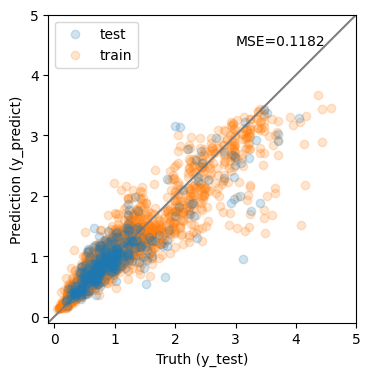

In [33]:
y_predict = rf.predict(X_test)
y_predict0 = rf.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

The results are much improved by the random forest! 

However, we must be cautious. It is possible that this model suffers from **over-fitting**. To visualize overfitting, we can compare the mean squared error (MSE) for models of increasing max_depth on the training and testing sets:

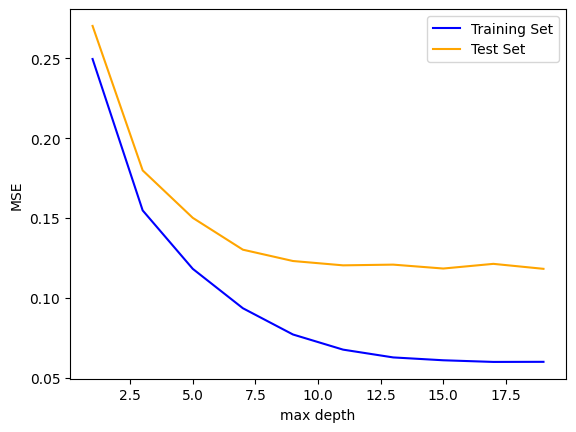

In [34]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []

params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
}

for depth in max_depths:

    rff_ = RandomForestRegressor(max_depth=depth, **params)
    rff_.fit(X_train, y_train)

    y_predict_train = rff_.predict(X_train)
    y_predict_test = rff_.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))


fig, ax = plt.subplots(1, 1)

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

Beyond a max_depth of ~10, the MSE on the training set declines while the MSE on the test set flattens out, suggesting some amount of over-fitting.

To explore further, we will explore how general our model performance (here quantifed with MSE) is using k-fold cross-validation via sklearn. In practice, the X and y datasets are split into k “folds”, and over k iterations, the model is trained using k-1 folds as training data and the remaining fold as a test set to compute performace (i.e., MSE).

In [35]:
from sklearn.model_selection import cross_validate

cv = cross_validate(
    estimator=rf,
    X=df_x,
    y=df_y,
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.143 +/- 0.056


The previous MSE is consistent with the cross-validated MSE, suggesting that the model is not significantly over-fitting.

Next, we’ll observe which features are most important to the model predictions.

Text(0.5, 0, 'Feature importance')

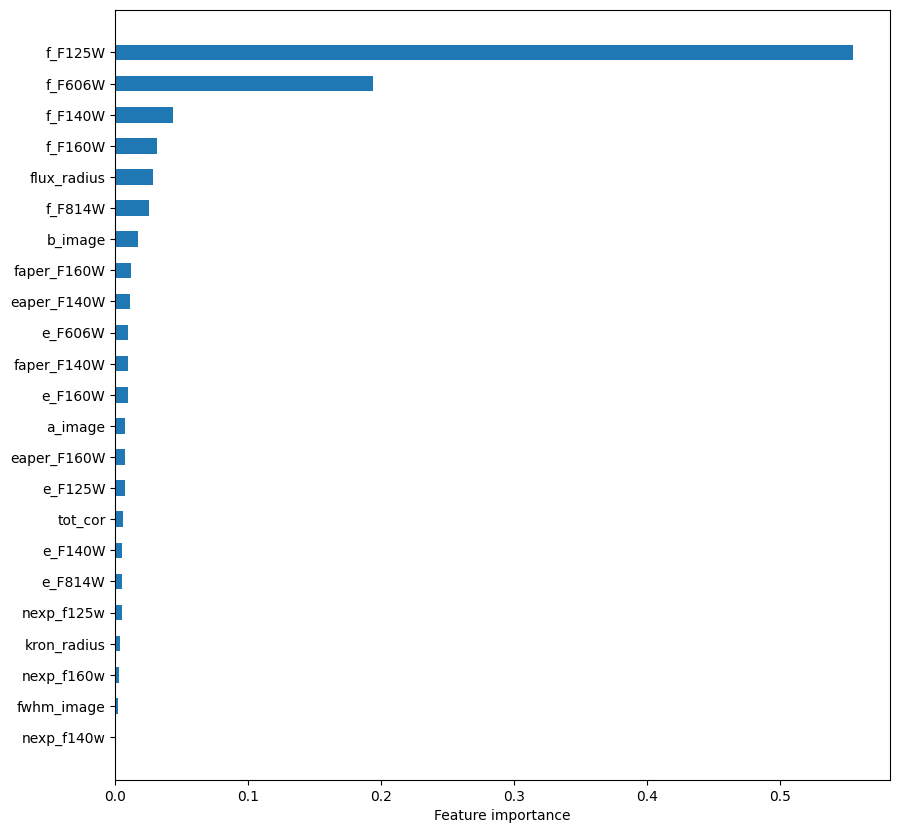

In [36]:
importances = rf.feature_importances_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort],
        align='center',
        height=0.5,
        tick_label=np.array(features)[argsort])
ax.set_xlabel("Feature importance")

#### Extratrees

In [43]:
from sklearn.ensemble import HistGradientBoostingRegressor


# Initialize the model
et = HistGradientBoostingRegressor()

et.fit(X_train, y_train)

HistGradientBoostingRegressor()

MSE = 0.1204


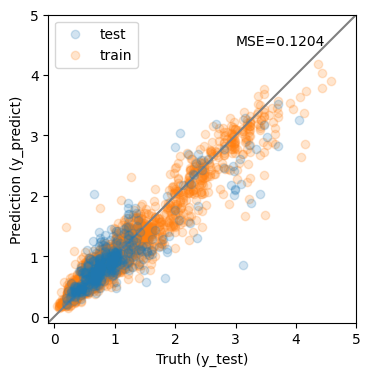

In [44]:
y_predict = et.predict(X_test)
y_predict0 = et.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

In [ ]:
cv = cross_validate(
    estimator=et,
    X=df_x,
    y=df_y,
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.144 +/- 0.053


In [45]:
pipe2 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingRegressor())
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('classifier', HistGradientBoostingRegressor())])

MSE = 0.1082


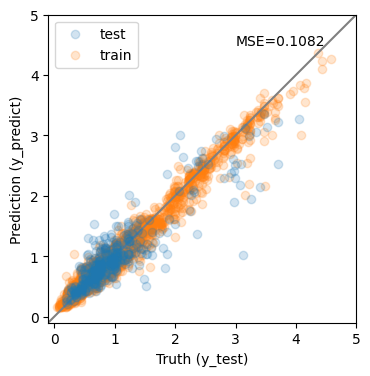

In [46]:
y_predict = pipe2.predict(X_test)
y_predict0 = pipe2.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

#### Check against each other and reference

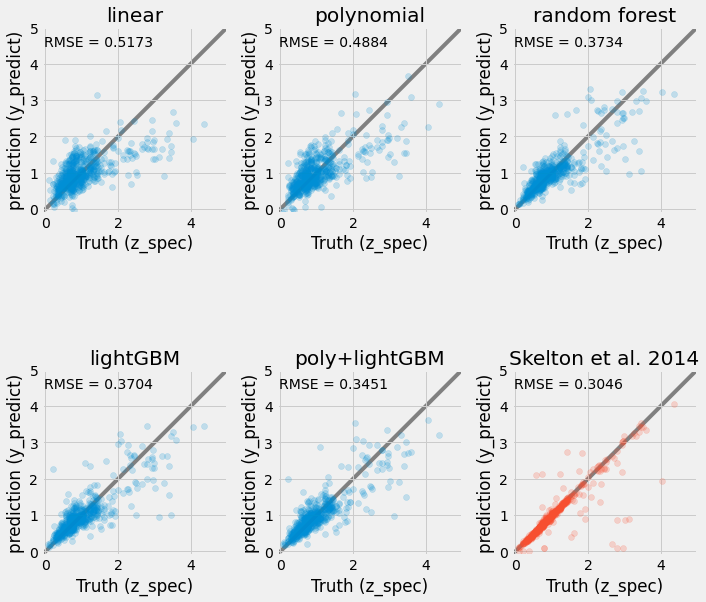

In [ ]:
y_values = [lin.predict(X_test),
            pipe.predict(X_test),
            rf.predict(X_test),
            et.predict(X_test),
            pipe2.predict(X_test),
            df['z_peak'].loc[X_test.index]
]

names = ['linear', 'polynomial', 'random forest', 'lightGBM', 'poly+lightGBM', 'Skelton et al. 2014']


fig, ax = plt.subplots(2, len(names) // 2 , figsize=(10, 10))

for k, (ax, yval) in enumerate(zip(np.ravel(ax), y_values)):
    color = 'C0'
    if k == len(names) - 1:
        color = 'C1'
    ax.scatter(y_test, yval, alpha=0.2, color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 5)
    ax.set_ylim(-0.1, 5)
    ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
    ax.set_xlabel('Truth (z_spec)')
    ax.set_ylabel('prediction (y_predict)')
    ax.set_title(names[k])
    mse = mean_squared_error(y_test, yval, squared=False)
    ax.text(0.01, 0.9, f'RMSE = {mse:.4f}', transform=ax.transAxes)

plt.tight_layout()

### Going further

* What if you include galaxy colors (e.g., F125W-F140W, F140W-F160W, F606W-F125W)? do the model results improve? Can you think of other features to include?

* Can you tune the model parameters with a grid search? 

* What if you try other models from sklearn?

MSE: 0.14376234464783927


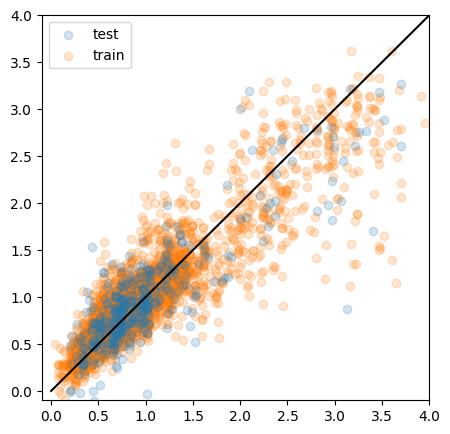

In [42]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='tanh')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred0 = mlp.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_pred, alpha=0.2, label="test")
ax.scatter(y_train, y_pred0, alpha=0.2, label='train', zorder = -1)
ax.plot([0, 4], [0, 4], color='black')
#ax.set_xlabel(“z_spec”)
#ax.set_ylabel(“z_pred”)
ax.set_xlim(-0.1, 4)
ax.set_ylim(-0.1, 4)
ax.legend()
plt.show()